In [8]:
import os, sys
sys.path.append(os.path.join("..")) #to access model class
# here go all the imports
import torch
from torch import nn
from torch.utils.data import Dataset
from tqdm import tqdm
from collections import OrderedDict, Counter
import random
import numpy as np
import matplotlib.pyplot as plt
import json
from model import Model
from dataprocess import *
import torch.optim as optim

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED) #I used gpu mainly for training
torch.backends.cudnn.deterministic = True

# Model resources creation

In principle I wanted to go for the same embeddings I used for the bonus exercise (word2vec), unluckily it lacks of many important words for this task so, also to try to obtain a bonus point, I decided to download an external embeddings (glove) and create my own vocabulary and embedding layers to import later and start the training with it.

In [ ]:
!wget https://nlp.stanford.edu/data/glove.840B.300d.zip --directory-prefix ../../model #I downloaded it from https://nlp.stanford.edu/projects/glove/
!unzip ../../model/glove.840B.300d.zip
!wget https://nlp.stanford.edu/data/glove.6B.zip --directory-prefix ../../model
!unzip ../../model/glove.6B.zip

This function create the vocabulary (word-id) and the embedding (id-vector)

In [ ]:
def load_model(glove_filepath,size=300):
    with open(glove_filepath, encoding="utf8" ) as f:
        model = OrderedDict()
        mapvocab = OrderedDict()
        tot=np.zeros(size,dtype='float32')
        id=0
        for l in f:
            line=l.split(' ')
            word=line[0]
            # we do not register the unk an pad token if already in dict 
            # or the word if already registered - I noticed this in 840B glove embedding with a -not utf- word
            if word in ["<UNK>","<PAD>"] or word in mapvocab: 
                print(word)
                continue
            embedding = np.asarray(line[1:],dtype='float64')
            tot+=embedding
            mapvocab[word] = id
            model[id] = embedding
            id+=1
        mapvocab['<UNK>']=id
        model[id]=tot/id #unk token is the average of every other 
        mapvocab['<PAD>']=id+1
        model[id+1]=np.zeros(size,dtype='float64')
    return model,mapvocab

In [ ]:
#define the path without the extension
vocab_path = "../../model/glove.6B.300d" #alternative eg: "../../model/glove.840B.300d"
embedding_size=300 #depends from which glove you are using, if eg 6B.100d the dimension is 100
model,mapvocab= load_model(vocab_path+".txt",size=embedding_size)
print(mapvocab['<PAD>'])

In [ ]:
#these values must be equal or there is an error in the vocabulary
print(len(model.keys()))
print(len(mapvocab))

I use json to save the imported dictionary from the txt file downloaded, it will be used later to encode words (and punctuation symbols) in a specific index that the embedding, saved below, will encode in a tensor.

In [ ]:
#save map dictionary 
with open(vocab_path+'.json', 'w') as file:
     file.write(json.dumps(mapvocab))

In [ ]:
#is it possible to fine-tunin embedding, compare with fine tune and with not, so for now I load it.
embedding_layer = torch.nn.Embedding.from_pretrained(torch.from_numpy(np.vstack(list(model.values()))))

In [ ]:
torch.save(embedding_layer.state_dict(),vocab_path+"_embedding.pth")

# Data Analysis and Extension

The code that follows allows me to estimate the goodness of a vocabulary according to some performance metrics I realized, for instance I counted the number of sentences, between the ones in the training set, that has at least one word that is labelled with a tag different from "O" (call them important words) that does not appear in our vocabulary, so I refer to these sentences as "dirty sentences" because I fell like I'm losing something that will be useful for the training (confirmed with later experiment), I'll filter out too dirty sentences.

In [ ]:
from evaluate import read_dataset #imported this function from a file provided to us to avoid re-writing it.

tokens_s, labels_s = read_dataset("../../data/train.tsv")

In [ ]:
print(len(tokens_s))
print(len(labels_s))

In [ ]:
#here I did an experiment to reduce the vocabulary size using only words that appear in the traning set, the result is not really good. 

# all_words=Counter()
# for s in tokens_s:
#     all_words.update(s)
# new_model = OrderedDict()
# new_mapvocab = OrderedDict()
# new_id=0
# for w in set(all_words.keys()).union({"'","!",":",",","+",'<UNK>','<PAD>'}):
#     id=mapvocab.get(w,-10)
#     if id<0:
#         continue
#     new_mapvocab[w]=new_id
#     new_model[new_id]=model[id]
#     new_id+=1
# mapvocab=new_mapvocab
# model=new_model
# print(len(new_model.keys()))
# print(len(new_mapvocab))

In [ ]:
vocab_pth="../../model/glove.6B.300d_extended2.json"
with open(vocab_pth, 'r') as file:
    vocab = json.load(file)

In [ ]:
vocab=mapvocab #if defined map vocab take it, otherwise just json-load it. ^

In [ ]:
token_size=len(tokens_s)
sentences_size=list()
k=0
for s,l in zip(tokens_s,labels_s):
    sentences_size.append(len(s))
    for w,lab in zip(s,l):
        if not w in vocab and lab!="O":
            k+=1
print("important words lost",k)
k=0
for s,l in zip(tokens_s,labels_s):
    for w,lab in zip(s,l):
        if not w in vocab and lab!="O":
            k+=1
            break
print("percentage of dirty sentences",k/token_size) #sentences that contains an OOV word but with a significant label !=0

sent_np=np.asarray(sentences_size)
print("mean",sent_np.mean())
print("std",sent_np.std())
print("min",sent_np.min())
print("max",sent_np.max())

plt.figure(figsize=(8,8)) #to increase the plot size
_ = plt.hist(sent_np, bins='auto') 
plt.title("Histogram of sentences size available") 
plt.show()

flat_labels = sum(labels_s,[]) #to flat the list
count=Counter(flat_labels)
plt.figure(figsize=(10,10))
_ = plt.bar(count.keys(),count.values()) 
plt.title("Bar Plot of labels frequency") 
plt.show() #it's possible to notice that most of them are between size 7 and 30

In a typical situation I would not care about OOV words, but the aim of this homework is to **focus on detecting semantically ambiguous and complex entities in short and low-context settings** so (almost) every word is precious, I decided to count how many words that do aren't in the vocabulary appear more than min_times and try to embed them using , the architecture will be trained not freezing the embedding layers to improve this randomness.

In [ ]:
min_times=1
oov_entities=Counter()
oov_not_entities=Counter()
for s,l in zip(tokens_s,labels_s):
    for w,lab in zip(s,l):
        if not w in vocab: 
            if lab!="O":
                oov_entities.update([w])
            else:
                oov_not_entities.update([w])

In [ ]:
print("entities")
print({k: c for k, c in oov_entities.items() if c > min_times})
#it's plenty of interesting words like women's that appear as named entities while simply women aren't, for this reason more than a cleanup of words 
#I prefer to proceed with my idea of using new vocabulary entries
print("most common entities")
print(oov_entities.most_common(20))
print("not entities")
print({k: c for k, c in oov_not_entities.items() if c > min_times})
#they are almost all useless words so we don't care about them.

In [ ]:
#this is the same word embed I used for the bonus exercise, I try to add missing words from it
import gensim.downloader as api
embed=api.load("word2vec-google-news-300")

In [ ]:
words_to_add=[k for k, c in oov_entities.items() if c > 1]
id=len(mapvocab) #we start from this id
embedding_dimension=model[0].shape[0]
for w in words_to_add:
    if w in embed:
        print(w)
        embedding = embed[w]
        mapvocab[w] = id
        model[id] = embedding
        id+=1

Moreover I want to add some special entries in the vocab "\<SPECIAL{punct}\>", it will be characterized by all ones - {punct embed} and it will be assigned to those words not in vocab but that have a {punct} in their sentence (so instead of directly \<UNK\>). Punct is a list of punctuation symbols that I have to establish. (note that this method need a vocab that embed punctuations)

In [ ]:
punct=["'","!",":",",","+"]
multiplier=3 #It is used to create the embed for special tokens starting from the associated punctuation.
for pun in punct:
    wspecial="<SPECIAL"+pun+">"
    embedding = multiplier*model[mapvocab[pun]]
    mapvocab[wspecial] = id
    model[id] = embedding
    id+=1

In [ ]:
#new len check
#these values must be equal or there is an error in the vocabulary
print(len(model.keys()))
print(len(mapvocab))

In [ ]:
#save extended dictionary 
with open(vocab_path+'_extended2.json', 'w') as file:
     file.write(json.dumps(mapvocab))

embedding_layer = torch.nn.Embedding.from_pretrained(torch.from_numpy(np.vstack(list(model.values()))))
torch.save(embedding_layer.state_dict(),vocab_path+"_extended_embedding2.pth")

# Training Dataset Filtering

In this section (procedure repeted below in training phase) I tested different combinations of parameters for my filter_sentences function that aim to filter out all the too dirty sentences.

In [ ]:
with open('../../model/glove.6B.300d_extended2.json', 'r') as file:
    vocab = json.load(file)

In [ ]:
from evaluate import read_dataset

tokens_s, labels_s = read_dataset("../../data/train.tsv")

In [ ]:
from dataprocess import *
#this allows me to choose the best samples for the training according to what I described above and specified better in the function: here I want to remove 
# too dirty sentences and 
new_sentences,new_labels=filter_sentences(tokens_s,labels_s ,vocab, 5, 40,filter_dirty=True)

In [ ]:
nd=NERDataset(new_sentences,vocab,labels=new_labels,window_size=30)

In [ ]:
print(nd[0])

# Model and Training

To speed up the hyperparameter tuning process and avoid to mess up with implementation file, here I pasted the Student Model and define some variants of the final model.

In [9]:

class HParams():
    vocab_size = 0 #it will be modified by StudentModel with the imported vocabulary
    embedding_dim = 300
    hidden_dim = 270
    num_classes = 13 # number of different NER classes for this homework
    bidirectional = True
    num_layers = 5
    dropout = 0.4
    trainable_embeddings = True 
    proj_size = 0
    scaling_classifier = 3
    model = None
    pretrained_path = None
    vocabulary_path = None
    embeddings_path = None

class StudentModel(Model):
    # STUDENT: construct here your model
    # this class should be loading your weights and vocabulary
    def __init__(self, device:str,hparams:HParams):
        self.device=device
        assert(hparams.vocabulary_path!=None)
        with open(hparams.vocabulary_path, 'r') as file:
            self.vocab = json.load(file)
            print(len(self.vocab))
        hparams.vocab_size=len(self.vocab)
        self.model = hparams.model(hparams).to(device)
        if hparams.pretrained_path!=None:
            self.model.load_state_dict(torch.load(hparams.pretrained_path,map_location=device)) #weights of the best model so far

    def predict(self, tokens: List[List[str]]) -> List[List[str]]:
        # STUDENT: implement here your predict function
        # remember to respect the same order of tokens!
        self.model.eval()
        window_size_ = 50 #!hyperparameter, use a large value to predict well
        nd=NERDataset(tokens,self.vocab,labels=None,window_size=window_size_)
        token_dataset=DataLoader(nd, batch_size=64, shuffle=False)
        res = list()
        for x in token_dataset:
            output=self.model.predict(x['inputs'].to(self.device))
            res+=sum(output,[]) #to flat the list
        res=nd.decode_output(res)
        predictions = list()
        #to keep the same order of tokens!
        for sentence in tokens:
            current_len=len(sentence)
            predict_sentence=list()
            for i in range(current_len):
                predict_sentence.append(res.pop(0))
            #we pop out the useless results computed associated to <pad> tokens
            if current_len%window_size_ != 0:
                for j in range(window_size_-(current_len%window_size_)):
                    res.pop(0)
            predictions.append(predict_sentence)
        assert(len(res) == 0) #res should be empty to perfectly match all the required tags
        return predictions
        
# this model is based on POSTaggerModel from notebook #6
class NERModel(nn.Module):
    # we provide the hyperparameters as input
    def __init__(self, hparams):
        super(NERModel, self).__init__()
        self.word_embedding = nn.Embedding(hparams.vocab_size, hparams.embedding_dim)
        if hparams.embeddings_path is not None:
            self.word_embedding.load_state_dict(torch.load(hparams.embeddings_path))
            if hparams.trainable_embeddings:
                for param in self.word_embedding.parameters(): #to freeze training parameters
                    param.requires_grad = False    

        self.lstm = nn.LSTM(hparams.embedding_dim, hparams.hidden_dim, 
                            bidirectional=hparams.bidirectional,
                            num_layers=hparams.num_layers, 
                            dropout = hparams.dropout if hparams.num_layers > 1 else 0,
                            batch_first=True,
                            proj_size=hparams.proj_size)
        lstm_output_dim = hparams.hidden_dim if hparams.bidirectional is False else hparams.hidden_dim * 2
        self.dropout = nn.Dropout(hparams.dropout)
        self.classifier=nn.Linear(lstm_output_dim,hparams.num_classes)

    def forward(self, x):
        embeddings = self.word_embedding(x)
        embeddings = self.dropout(embeddings)
        o, (h, c) = self.lstm(embeddings)
        o = self.dropout(o)
        return self.classifier(o)
    def predict(self,x):
        out = self(x)
        return torch.argmax(out,-1).tolist()
# extended with MLP as classifier
class NERModel_MLP(nn.Module):
    # we provide the hyperparameters as input
    def __init__(self, hparams):
        super(NERModel_MLP, self).__init__()
        self.word_embedding = nn.Embedding(hparams.vocab_size, hparams.embedding_dim)
        if hparams.embeddings_path is not None:
            self.word_embedding.load_state_dict(torch.load(hparams.embeddings_path))
            if hparams.trainable_embeddings:
                for param in self.word_embedding.parameters(): #to freeze training parameters
                    param.requires_grad = False    

        self.lstm = nn.LSTM(hparams.embedding_dim, hparams.hidden_dim, 
                            bidirectional=hparams.bidirectional,
                            num_layers=hparams.num_layers, 
                            dropout = hparams.dropout if hparams.num_layers > 1 else 0,
                            batch_first=True,
                            proj_size=hparams.proj_size)
        lstm_output_dim = hparams.hidden_dim if hparams.bidirectional is False else hparams.hidden_dim * 2
        self.dropout = nn.Dropout(hparams.dropout)
        #build classifier multilayer perceptron
        self.classifier=nn.ModuleList()
        i=lstm_output_dim
        j=hparams.scaling_classifier
        while(i>j*j*hparams.num_classes):
            print(i)
            self.classifier.append(nn.Sequential(
                nn.Linear(i,int(i/j)),
                nn.ReLU(),  
                nn.Dropout(hparams.dropout) 
            ))
            i=int(i/j)
        self.final=nn.Linear(i,hparams.num_classes)

    def forward(self, x):
        embeddings = self.word_embedding(x)
        embeddings = self.dropout(embeddings)
        o, (h, c) = self.lstm(embeddings)
        o = self.dropout(o)
        for layer in self.classifier:
            o=layer(o)
        return self.final(o)
    def predict(self,x):
        out = self(x)
        return torch.argmax(out,-1).tolist()
#extended sequence embeding model
class NERModel_gru(nn.Module):
    # we provide the hyperparameters as input
    def __init__(self, hparams):
        super(NERModel_gru, self).__init__()
        self.word_embedding = nn.Embedding(hparams.vocab_size, hparams.embedding_dim)
        if hparams.embeddings_path is not None:
            self.word_embedding.load_state_dict(torch.load(hparams.embeddings_path))
            if hparams.trainable_embeddings:
                for param in self.word_embedding.parameters(): #to freeze training parameters
                    param.requires_grad = False    

        self.lstm = nn.LSTM(hparams.embedding_dim, hparams.hidden_dim, 
                            bidirectional=hparams.bidirectional,
                            num_layers=hparams.num_layers, 
                            dropout = hparams.dropout if hparams.num_layers > 1 else 0,
                            batch_first=True,
                            proj_size=hparams.proj_size)
        self.gru = nn.GRU(hparams.embedding_dim, hparams.hidden_dim, 
                            bidirectional=hparams.bidirectional,
                            num_layers=hparams.num_layers, 
                            dropout = hparams.dropout if hparams.num_layers > 1 else 0,
                            batch_first=True)
        lstm_output_dim = hparams.hidden_dim if hparams.bidirectional is False else hparams.hidden_dim * 2
        self.dropout = nn.Dropout(hparams.dropout)
        self.classifier = nn.Linear(lstm_output_dim*2, hparams.num_classes)

    def forward(self, x):
        embeddings = self.word_embedding(x)
        embeddings = self.dropout(embeddings)
        o, (h, c) = self.lstm(embeddings)
        o2, h2 = self.gru(embeddings)
        o = self.dropout(o)
        o2 = self.dropout(o2)
        # print(o.shape,o2.shape)
        otot=torch.cat([o,o2],dim=-1)
        # print(otot.shape)
        output = self.classifier(otot)
        return output
    def predict(self,x):
        out = self(x)
        return torch.argmax(out,-1).tolist()
    
from my_crf import CRF
class NERModel_crf(nn.Module):
    # we provide the hyperparameters as input
    def __init__(self, hparams):
        super(NERModel_crf, self).__init__()
        self.word_embedding = nn.Embedding(hparams.vocab_size, hparams.embedding_dim)
        if hparams.embeddings_path is not None:
            self.word_embedding.load_state_dict(torch.load(hparams.embeddings_path))
            if hparams.trainable_embeddings:
                for param in self.word_embedding.parameters(): #to freeze training parameters
                    param.requires_grad = False    

        self.lstm = nn.LSTM(hparams.embedding_dim, hparams.hidden_dim, 
                            bidirectional=hparams.bidirectional,
                            num_layers=hparams.num_layers, 
                            dropout = hparams.dropout if hparams.num_layers > 1 else 0,
                            batch_first=True,
                            proj_size=hparams.proj_size)
        lstm_output_dim = hparams.hidden_dim if hparams.bidirectional is False else hparams.hidden_dim * 2
        self.dropout = nn.Dropout(hparams.dropout)
        self.classifier=nn.Linear(lstm_output_dim,hparams.num_classes)
        self.crf=CRF(hparams.num_classes,batch_first=True)

    def forward(self, x):
        embeddings = self.word_embedding(x)
        embeddings = self.dropout(embeddings)
        o, (h, c) = self.lstm(embeddings)
        o = self.dropout(o)
        return self.classifier(o)
    
    def predict(self,x):
        out=self(x)
        return self.crf.decode(out)

In [10]:
#hparams declaration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
hparams=HParams()
hparams.vocabulary_path='../../model/glove.6B.300d_extended2.json'#model/glove.6B.300d.json
hparams.embeddings_path="../../model/glove.6B.300d_extended_embedding2.pth"
hparams.model=NERModel
# baseline settings, uncomment to try it (need to create the resources as stated above)
# hparams.hidden_dim = 128
# hparams.embedding_dim = 100
# hparams.bidirectional = False
# hparams.num_layers = 1
# hparams.trainable_embeddings = True 
# hparams.dropout = 0.0
# hparams.vocabulary_path='../../model/glove.6B.100d.json' #model/glove.6B.100d.json
# hparams.embeddings_path="../../model/glove.6B.100d_embedding.pth"

In [11]:
model=StudentModel(device,hparams)

400022


In [12]:
model.predict([["ciao","tu","come","stai","?"],["io","molto","bene"]])

[['B-PROD', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC'], ['B-PROD', 'I-LOC', 'I-LOC']]

In [13]:
from evaluate import read_dataset
#dataset and dataloader preparation
with open(hparams.vocabulary_path, 'r') as file:
    vocab = json.load(file)

window_size_=50 #it is large enough to contains all the training sentences and does not lost context informations

tokens_s, labels_s = read_dataset("../../data/train.tsv")
new_sentences,new_labels=filter_sentences(tokens_s,labels_s ,vocab, 5, 41,filter_dirty=True)
nd=NERDataset(new_sentences,vocab,labels=new_labels,window_size=window_size_)
train_dataset=DataLoader(nd, batch_size=128, shuffle=True,num_workers=8)

tokens_val, labels_val = read_dataset("../../data/dev.tsv")
valid_dataset=DataLoader(NERDataset(tokens_val,vocab,labels=labels_val,window_size=window_size_), batch_size=128, shuffle=False)

filtered out 68 sentences


To avoid to run docker every time I decided to copy paste from evaluate the functions that I need to compute my f1, encapsulated in a function so that I can print it at training time evaluation step. Here I also added an utility to plot confusion matrix when the complex plot parameter "plot_c" is set to true.

In [14]:
from evaluate import flat_list, count
from seqeval.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def compute_f1(model_,tokens_val_=tokens_val,labels_val_=labels_val,plot_c=False):
    model=model_
    predictions_s=model.predict(tokens_val_)

    flat_labels_s = flat_list(labels_val_)
    flat_predictions_s = flat_list(predictions_s)

    label_distribution = count(flat_labels_s)
    pred_distribution = count(flat_predictions_s)

    if plot_c:
        keys = set(label_distribution.keys()) | set(pred_distribution.keys())
        print(f"# instances: {len(flat_list(labels_val_))}")
        for k in keys:
            print(
                f"\t# {k}: ({label_distribution.get(k, 0)}, {pred_distribution.get(k, 0)})"
            )

    acc = accuracy_score(labels_val_, predictions_s)
    f = f1_score(labels_val_, predictions_s, average="macro")
    f2 = f1_score(labels_val_, predictions_s, average="micro")

    print(f"# accuracy: {acc:.4f}")
    print(f"# f1 (macro): {f:.4f}") #71.62
    #plot confusion matrix and f1 (micro)
    if plot_c:
        print(f"# f1 (micro): {f2:.4f}")
        all_labels=labels=[*NERDataset.label_encoding.keys()][:-2]
        # fig, ax = plt.subplots()
        cm = confusion_matrix(flat_labels_s, flat_predictions_s, labels=all_labels,normalize="true")
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=all_labels)
        fig, ax = plt.subplots(figsize=(15,15))
        disp.plot(ax=ax) #7162
    return f

In [15]:
#standard NLP class used in many Notebooks and that I used also in the bonus exercise. Slightly changed by me.
class Trainer():
    """Utility class to train and evaluate a model."""

    def __init__(
        #! these are things you need to design and discuss for your homework.
        self,
        model: StudentModel,
        loss_function,
        optimizer,
        device,
        log_steps:int=10_000,
        log_level:int=2,
        crf:bool=False):
        """
        Args:
            model: the model we want to train.
            loss_function: the loss_function to minimize.
            optimizer: the optimizer used to minimize the loss_function.
        """
        self.student_model = model
        self.model = self.student_model.model
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.device = device
        self.log_steps = log_steps
        self.log_level = log_level
        self.crf=crf
         #I want to save the story of my training to plot it
        self.all_f1_scores = list()
        self.all_train_loss = list()
        self.all_valid_loss = list()
        
    def train(self, train_dataset:Dataset, 
              valid_dataset:Dataset, 
              epochs:int=1):
        """
        Args:
            train_dataset: a Dataset or DatasetLoader instance containing
                the training instances.
            valid_dataset: a Dataset or DatasetLoader instance used to evaluate
                learning progress.
            epochs: the number of times to iterate over train_dataset.

        Returns:
            avg_train_loss: the average training loss on train_dataset over
                epochs.
        """
        assert epochs > 1 and isinstance(epochs, int)
        if self.log_level > 0:
            print('Training ...')
        
        train_loss = 0.0
        for epoch in range(epochs):
            if self.log_level > 0:
                print(' Epoch {:03d}'.format(epoch + 1))

            epoch_loss = 0.0
            self.model.train()

            # for each batch 
            for step, sample in enumerate(train_dataset):
                inputs = sample['inputs'].to(self.device)
                labels = sample['outputs'].to(self.device)
                self.optimizer.zero_grad()

                predictions = self.model(inputs)
                
                if self.crf: #I tried also crf here, does not use crossentropy!!
                    mask=(labels<13) #we need to mask labels 13 of the <PAD> token.
                    # conditional log likelihood (opposite sign to have a positive value)
                    sample_loss = -self.model.crf(predictions,labels,mask=mask,reduction="sum")
                else:    
                    labels = labels.view(-1)
                    predictions = predictions.view(-1, predictions.shape[-1])
                    sample_loss = self.loss_function(predictions, labels)
                sample_loss.backward()
                self.optimizer.step()

                epoch_loss += sample_loss.tolist()

                if self.log_level > 1 and step % self.log_steps == self.log_steps - 1:
                    print('\t[E: {:2d} @ step {}] current avg loss = {:0.4f}'.format(epoch, step, epoch_loss / (step + 1)))
            
            avg_epoch_loss = epoch_loss / len(train_dataset)
            self.all_train_loss.append(avg_epoch_loss)
            train_loss += avg_epoch_loss
            if self.log_level > 0:
                print('\t[E: {:2d}] train loss = {:0.4f}'.format(epoch, avg_epoch_loss))

            valid_loss = self.evaluate(valid_dataset)
            self.all_valid_loss.append(valid_loss)
            if self.log_level > 0:
                print('  [E: {:2d}] valid loss = {:0.4f}'.format(epoch, valid_loss))

        if self.log_level > 0:
            print('... Done!')
        avg_epoch_loss = train_loss / epochs
        return avg_epoch_loss
    
    def evaluate(self, valid_dataset):
        """
        Args:
            valid_dataset: the dataset to use to evaluate the model.

        Returns:
            avg_valid_loss: the average validation loss over valid_dataset.
        """
        valid_loss = 0.0
        # set dropout to 0!! Needed when we are in inference mode.
        self.model.eval()
        with torch.no_grad():
            for sample in valid_dataset:
                inputs = sample['inputs'].to(self.device)
                labels = sample['outputs'].to(self.device)
                predictions = self.model(inputs)
                if self.crf:
                    mask=(labels<13)
                    sample_loss = -self.model.crf(predictions,labels,mask=mask,reduction="sum")
                else:
                    predictions = predictions.view(-1, predictions.shape[-1])
                    labels = labels.view(-1)
                    sample_loss = self.loss_function(predictions, labels)
            valid_loss += sample_loss.tolist()
            self.all_f1_scores.append(compute_f1(self.student_model))
            #utility to save model when its f1 score on dev set beats my record
            if self.all_f1_scores[-1]>0.75:
                print("saving good model...",self.all_f1_scores[-1])
                torch.save(self.model.state_dict(), "../../model/NERModelv270_{:0.4f}.pth".format(self.all_f1_scores[-1]))
        
        return valid_loss / len(valid_dataset)

In [16]:
trainer = Trainer(
    model = model,
    loss_function = nn.CrossEntropyLoss(ignore_index=NERDataset.label_encoding['<PAD>']),
    optimizer = optim.Adam(model.model.parameters(),weight_decay=1e-6),
    device=device,
    crf=isinstance(model.model,NERModel_crf)
)

In [ ]:
#used for the baseline plot
trainer2 = Trainer(
    model = model,
    loss_function = nn.CrossEntropyLoss(ignore_index=NERDataset.label_encoding['<PAD>']),
    optimizer = optim.Adam(model.model.parameters(), lr=1e-4,weight_decay=1e-6),
    device=device
)

In [17]:
epochs = 5 
trainer.train(train_dataset, valid_dataset, epochs)

Training ...
 Epoch 001
	[E:  0] train loss = 0.9652
# accuracy: 0.8270
# f1 (macro): 0.0643
  [E:  0] valid loss = 0.1105
 Epoch 002
	[E:  1] train loss = 0.5657
# accuracy: 0.8795
# f1 (macro): 0.2744
  [E:  1] valid loss = 0.0725
 Epoch 003
	[E:  2] train loss = 0.4100
# accuracy: 0.8954
# f1 (macro): 0.3768
  [E:  2] valid loss = 0.0677
 Epoch 004
	[E:  3] train loss = 0.3399
# accuracy: 0.9142
# f1 (macro): 0.5341
  [E:  3] valid loss = 0.0517
 Epoch 005
	[E:  4] train loss = 0.2990
# accuracy: 0.9215
# f1 (macro): 0.5768
  [E:  4] valid loss = 0.0448
... Done!


0.5159586476652246

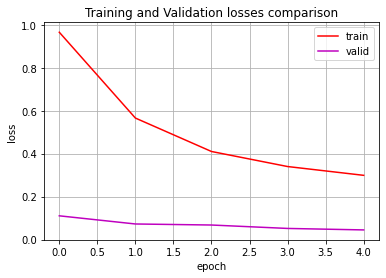

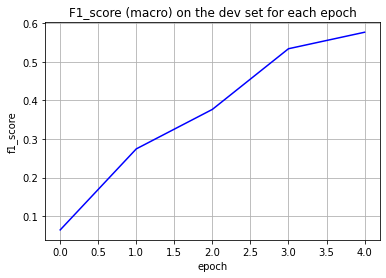

In [18]:
X=np.arange(len(trainer.all_f1_scores))

plt.plot(X, trainer.all_train_loss, color='r', label='train')
plt.plot(X, trainer.all_valid_loss, color='m', label='valid')
# plt.plot(X, trainer2.all_train_loss, color='g', label='train (baseline)')
# plt.plot(X, trainer2.all_valid_loss, color='c', label='valid (baseline)')
  
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training and Validation losses comparison")
plt.legend()
plt.grid()
plt.show()

plt.plot(X, trainer.all_f1_scores, color='b',label='') 
# plt.plot(X, trainer2.all_f1_scores, color='c',label='(baseline)') 
plt.xlabel("epoch")
plt.ylabel("f1_score")
plt.title("F1_score (macro) on the dev set for each epoch")
# plt.legend()
plt.grid()
plt.show()

# instances: 12751
	# I-CORP: (119, 138)
	# I-CW: (261, 166)
	# B-CORP: (133, 135)
	# I-LOC: (153, 125)
	# I-GRP: (377, 266)
	# B-LOC: (243, 230)
	# B-PROD: (149, 101)
	# O: (10240, 10666)
	# I-PER: (329, 333)
	# B-PER: (300, 290)
	# I-PROD: (87, 78)
	# B-GRP: (190, 126)
	# B-CW: (170, 97)
# accuracy: 0.9215
# f1 (macro): 0.5768
# f1 (micro): 0.6335


0.576827477342926

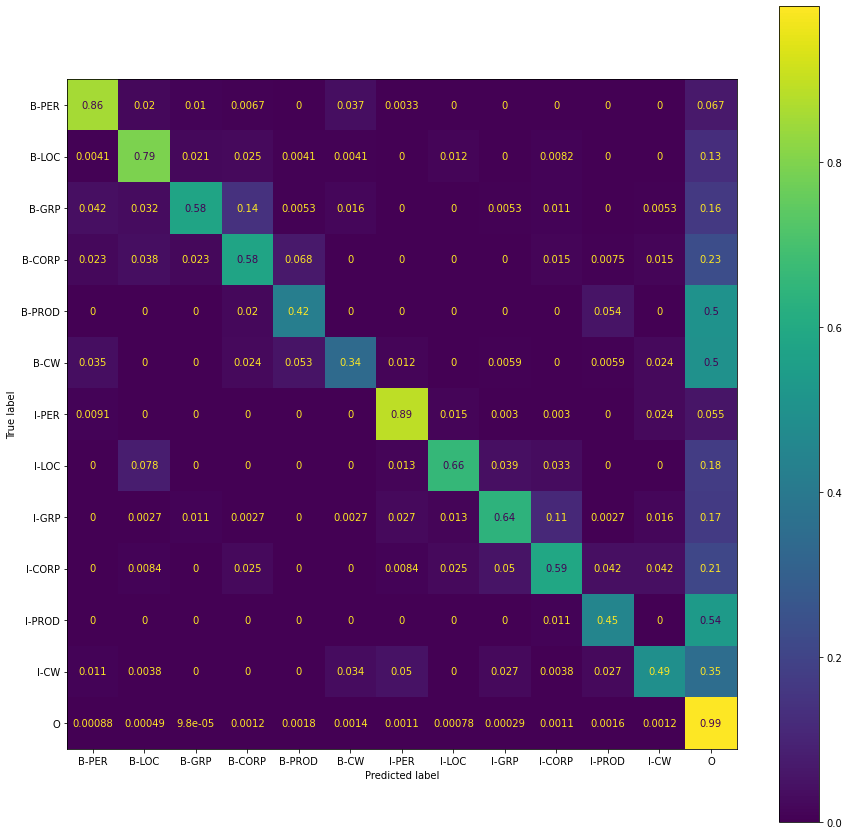

In [19]:
compute_f1(model,plot_c=True)

400022


/home/dennis/Desktop/NLP_hw1/hw1/stud/my_crf.py:309: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorCompare.cpp:255.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


# instances: 12751
	# I-CORP: (119, 107)
	# I-CW: (261, 248)
	# B-CORP: (133, 120)
	# I-LOC: (153, 131)
	# I-GRP: (377, 361)
	# B-LOC: (243, 235)
	# B-PROD: (149, 138)
	# O: (10240, 10327)
	# I-PER: (329, 345)
	# B-PER: (300, 312)
	# I-PROD: (87, 90)
	# B-GRP: (190, 188)
	# B-CW: (170, 149)
# accuracy: 0.9504
# f1 (macro): 0.7566
# f1 (micro): 0.7899


0.7565688406133

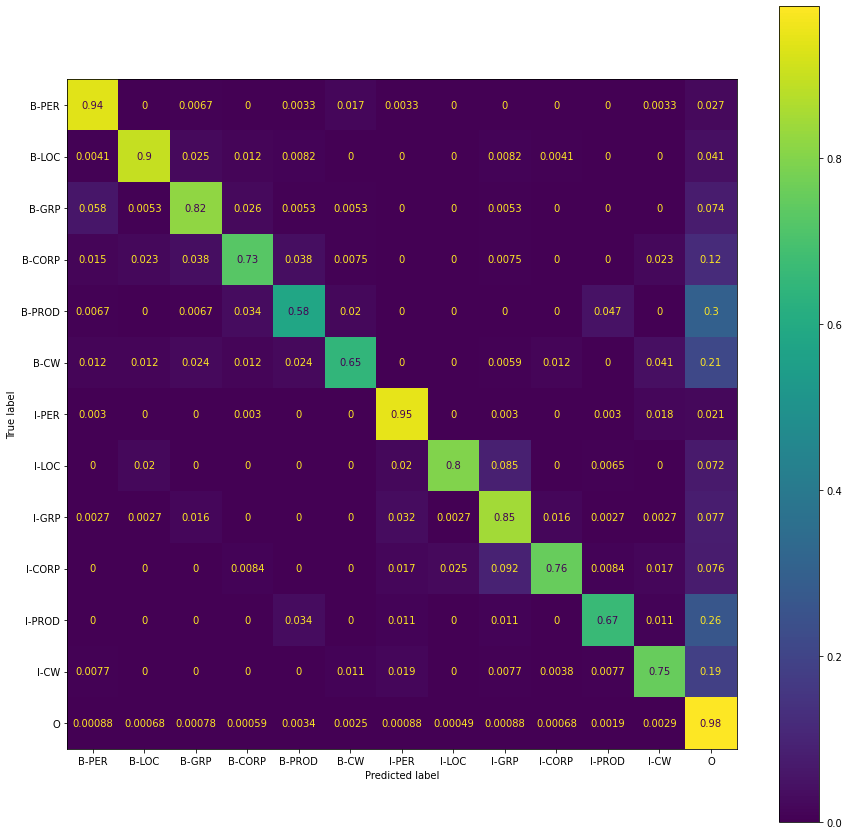

In [20]:
#comparison with the best single network so far
hparamsBest = HParams()
hparamsBest.pretrained_path = "../../model/NERModelv270e3_crf7566.pth"
hparamsBest.vocabulary_path = '../../model/glove.6B.300d_extended2.json'
hparamsBest.model=NERModel_crf
best_model=StudentModel(device,hparamsBest)
compute_f1(best_model,plot_c=True)

In [ ]:
#https://arxiv.org/abs/2109.08203 strategy
for i in range(100): 
    tmpmod=StudentModel(device,hparams)
    trainer2 = Trainer(
        model = tmpmod,
        loss_function = nn.CrossEntropyLoss(ignore_index=NERDataset.label_encoding['<PAD>']),
        optimizer = optim.Adam(tmpmod.model.parameters(),weight_decay=1e-6),
        device=device,
        crf=isinstance(tmpmod.model,NERModel_crf)
    )
    epochs= 100 #in 92 epochs I found the best model so far
    trainer2.train(train_dataset, valid_dataset, epochs)

For the sake of completeness I report here this ensemble models experiment, as stated in the report it improve little more ~ 0.02 the f1 score.

In [21]:
class Ensemble_model(Model):
    """_summary_
        Generic class for "Model" models, it take as input a list of "Model" and predict using
         a majority voting with uniform weights for each of them.
    """
    def __init__(self,models:list):
        self.num_models=len(models)
        self.models=models
    def predict(self, tokens: List[List[str]]) -> List[List[str]]:
        all_predictions=list() #list that will contains the predictions for each model
        for mod in self.models:
             all_predictions.append(mod.predict(tokens))
        ensemble_predict=list()
        for mixpred in zip(* all_predictions): #we zip the prediction of each sentence for each model
            tmp_pred=list()
            for i in range(len(mixpred[0])):
                #create the list with the  word predict for each model and predict with the most common result
                tmp=[mixpred[j][i] for j in range(self.num_models)]
                tmp_pred.append(max(tmp,key=tmp.count))
            ensemble_predict.append(tmp_pred)
        return ensemble_predict

400022
400022
400022
400022
400022
# instances: 12751
	# I-CORP: (119, 94)
	# I-CW: (261, 254)
	# B-CORP: (133, 113)
	# I-LOC: (153, 136)
	# I-GRP: (377, 358)
	# B-LOC: (243, 246)
	# B-PROD: (149, 132)
	# O: (10240, 10341)
	# I-PER: (329, 342)
	# B-PER: (300, 316)
	# I-PROD: (87, 80)
	# B-GRP: (190, 176)
	# B-CW: (170, 163)
# accuracy: 0.9544
# f1 (macro): 0.7763
# f1 (micro): 0.8041


0.7763382810162248

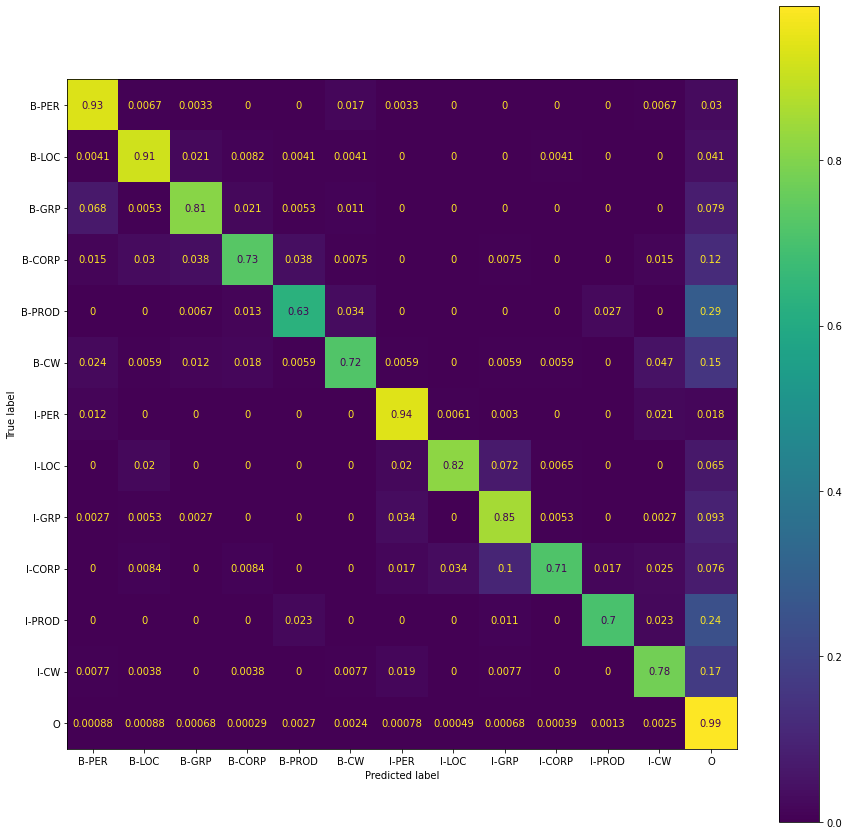

In [23]:
#best 77.6338 acc 0.9544
hparams.model=NERModel
hparams.pretrained_path = "../../model/NERModelv270e1_7454.pth"
model1=StudentModel(device,hparams)
hparams.model=NERModel
hparams.pretrained_path = "../../model/NERModelv270e2_7531.pth"
model2=StudentModel(device,hparams)
hparams.model=NERModel_crf
hparams.pretrained_path = "../../model/NERModelv270e3_crf7566.pth"
model3=StudentModel(device,hparams)
hparams.model=NERModel_crf
hparams.pretrained_path = "../../model/NERModelv270e4_crf7521.pth"
model4=StudentModel(device,hparams)
hparams.model=NERModel
hparams.pretrained_path = "../../model/NERModelv270e5_7431.pth"
model5=StudentModel(device,hparams)
models=[model1,model2,model3,model4,model5]
modens=Ensemble_model(models)
compute_f1(modens,plot_c=True) #to test on train set: tokens_val_=new_sentences,labels_val_=new_labels,

In [ ]:
torch.save(model.model.state_dict(), "../../model/NERModel***.pth") #save if good enough

In [ ]:
#utilty to load missmatched size models, to check if with old parameters I can do something
current_model_dict = model.model.state_dict()
loaded_state_dict = torch.load("../../model/NERModelv270_7531.pth",map_location=device)
new_state_dict={k:v if v.size()==current_model_dict[k].size()  else  current_model_dict[k] for k,v in zip(current_model_dict.keys(), loaded_state_dict.values())}
model.model.load_state_dict(new_state_dict, strict=False)